**Author**: Vinay Barnabas

In [210]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Is the Date birth same for multiple entries of patients?**

In [106]:
con = sqlite3.connect("techTest.db")
cur = con.cursor()


In [118]:
cur.execute('''
                SELECT name
                FROM sqlite_master
                WHERE type = "table";
            ''')

for item in cur.fetchall():
    print(f"Column Name: {item[0]}")
    print(50*"-")
    print("with columns")
    cur.execute(f"PRAGMA table_info({item[0]})")
    column_info = cur.fetchall()
    for col in column_info:
        print(col)
    print("\n")    

Column Name: patient
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'dob', 'TIMESTAMP', 0, None, 0)
(2, 'dod', 'TIMESTAMP', 0, None, 0)
(3, 'gender', 'TEXT', 0, None, 0)


Column Name: diagnosis
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'diagnosis_date', 'TIMESTAMP', 0, None, 0)
(2, 'diagnosis_code', 'TEXT', 0, None, 0)
(3, 'diagnosis_code_type', 'TEXT', 0, None, 0)


Column Name: biomarker
--------------------------------------------------
with columns
(0, 'patient_id', 'TEXT', 0, None, 0)
(1, 'test_date', 'TIMESTAMP', 0, None, 0)
(2, 'biomarker_name', 'TEXT', 0, None, 0)
(3, 'biomarker_test_type', 'TEXT', 0, None, 0)
(4, 'test_result', 'TEXT', 0, None, 0)




### Data Exploration and Cleaning

In [119]:
cur.execute('''
            SELECT p.patient_id,
            CASE
            WHEN MIN(p.dob) = MAX(p.dob) THEN 1
            ELSE 0
            END Is_dob_same

            FROM Patient as p
            GROUP BY p.patient_id
  
            
            ''')
count_is_same = 0
count_rows = 0
for item in cur.fetchall():
    count_rows+=1
    count_is_same+=item[1]

assert count_rows == count_is_same, "A patient has multiple dobs"


*Is DOB > DOD?*

In [120]:
cur.execute('''
            SELECT COUNT(*)
            FROM Patient
            WHERE dob > dod
            ''')
count_is_same = 0
count_rows = 0
assert cur.fetchall()[0][0] == 0, "Date of Birth is later than Date of death"

*Are DOD > TODAY?*

In [157]:
cur.execute('''
                SELECT COUNT(*)
                FROM patient
                WHERE STRFTIME("%Y",dod) > STRFTIME("%Y","now");
             
            ''')

num_dodbiggernow = cur.fetchone()[0]
print(f"Number of records in Patients table where date of death is greater than current date: {num_dodbiggernow}")

Number of records in Patients table where date of death is greater than current date: 174


*Is DOD earlier than earliest date of diagnosis?*

**OBSERVATION**: <br>
- There are multiple instances of patients. Hence multiples dates of diagnosis
- Date of births are the same for the grouped patients ids

In [221]:
#p.patient_id, STRFTIME("%Y",p.dod), STRFTIME("%Y", MIN(d.diagnosis_date)), STRFTIME("%Y", p.dod) - STRFTIME("%Y", MIN(d.diagnosis_date))
        
#MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis
cur.execute('''
            SELECT p.patient_id, p.dod, MIN(d.diagnosis_date)
            FROM Patient as p LEFT JOIN Diagnosis as d ON p.patient_id = d.patient_id 
            GROUP BY p.patient_id
            HAVING (d.diagnosis_code LIKE "C50%") AND p.dod < MIN(d.diagnosis_date)---  
            ''')
count_is_same = 0
query_records = cur.fetchall()
print(f"Number of records with DOD < Date of first diagnosis: {len(query_records)}")
con.commit()
con.close()

Number of records with DOD < Date of first diagnosis: 154


### Data maturity 
    - Calculate the summary statistics and plot the distribution of follow up time for BC patients.
    - Calculate the summary statistics and plot the distribution of age at initial diagnosis for BC patients

In [178]:
query = '''
        SELECT p.patient_id, STRFTIME("%Y",p.dod) - STRFTIME("%Y", MIN(d.diagnosis_date)) as follow_up_time, STRFTIME("%Y", MIN(d.diagnosis_date)) - STRFTIME("%Y",p.dob) as age_at_diagnosis, b.
        FROM Patient as p LEFT JOIN Diagnosis as d ON p.patient_id = d.patient_id LEFT JOIN biomarker as b on d.patient_id = b.patient_id 
        GROUP BY p.patient_id 
        HAVING d.diagnosis_code LIKE "C50%"
        '''

df = pd.read_sql_query(query, con)
print(f"Size of the table: {df.shape[0]} x {df.shape[1]}")
df.head()

Size of the table: 795 x 3


,patient_id,follow_up_time,age_at_diagnosis
0,0022fa14-8260-4b11-88cd-3fa066ede851,15,50
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,52,21
2,019d3689-e49a-4f23-8ca1-65379907230b,46,30
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,30,26
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,48,26


In [179]:
df_filter = df[df.follow_up_time > 0]
print(f"Size of the table: {df_filter.shape[0]} x {df_filter.shape[1]}")
df_filter.head()


Size of the table: 639 x 3


,patient_id,follow_up_time,age_at_diagnosis
0,0022fa14-8260-4b11-88cd-3fa066ede851,15,50
1,0183e236-7892-4aa9-8b7f-10f12676f1ec,52,21
2,019d3689-e49a-4f23-8ca1-65379907230b,46,30
3,01d468fc-55b8-45e3-8eca-dcb7a6185f28,30,26
4,022ff2bf-19d7-4c4d-8410-a91773ad24f2,48,26


In [194]:
df_filter.isna().sum()

patient_id          0
follow_up_time      0
age_at_diagnosis    0
dtype: int64

In [180]:
df_filter.describe()

,follow_up_time,age_at_diagnosis
count,639.000000,639.000000
mean,26.705790,30.513302
std,15.411426,10.009685
min,1.000000,19.000000
25%,14.000000,23.000000
50%,26.000000,28.000000
75%,38.000000,35.000000
max,62.000000,79.000000


In [208]:
np.isfinite(df_filter)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

c:\Users\vinay\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\vinay\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='age_at_diagnosis', ylabel='Density'>

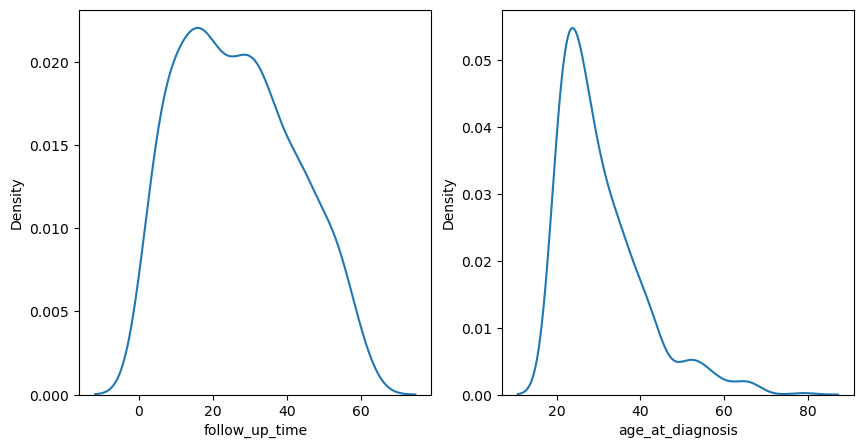

In [219]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

sns.kdeplot(
    df_filter,
    x = "follow_up_time",
    ax = axes[0]
)

sns.kdeplot(
    df_filter,
    x = "age_at_diagnosis",
    ax = axes[1]
)


### HER2 status
    - Calculate the intent to test rate for HER2. 
    - Calculate the tested rate for HER2.
    - Calculate the negativity rate for HER2.